# MaskRCNN Challenge

*In this challenge you will be asked to build a deep learning solution capable of segmenting turtles on synthetic images. You will be provided with the data, which you can use to train your models; your best model will be used on a test image and you will be asked to implement some geometric algorithms based on the predictions of your model.*

***Training data***

The training data will consist of 30 256x256 images of the same synthetic turtle pasted on background images artificially generated by BigGAN (https://arxiv.org/abs/1809.11096).

Feel free to increase the dataset size as needed and make any relevant changes to the dataset creation.

Each image will come with the ground truth per-pixel segmentation mask which you can leverage for your training setup. You should try and use Instance Segmentation methods over Semantic Segmentation as Instance Segmentation can handle multiple classes and objects, and also can be used for counting individual occurences of these objects.

You are also allowed to use external data sources and pre-trained weights, but please provide justification if you choose to do so.


***Test data***

There will only be a single test image without the provided GT.

The test image differs from the training data and it is up to you to decide how to approach these differences. Notably, the test image is of resolution 512x512 and your predicted mask must be of the same resolution.


***Tasks***

1. Your main task is to build a deep learning model capable of accurately segmenting the turtle in the test image. Preferred choice: MaskRCNN
2. Based on the segmentation mask predicted by your model, you will need to implement an algorithm that finds a convex hull, i.e. a polygon enclosing all the foreground (i.e. turtle) pixels.
3. Implement an algorithm that calculates the area of the polygon from the result of task 2.


***Rules***

* While we provide all the code in PyTorch, feel free to use other deep learning frameworks as needed
* Feel free to use all the imported Python libraries
* For tasks 2 and 3 ***you are not allowed*** to use third-party functions that readily solve those tasks, e.g. you are not allowed to use various `cv2` and `scikit-image` operators. We expect the algorithms to be based on points and geometry rather than full-image operations.


***Submission***

* ***You must send us only a single link to the Colab notebook with your solution and nothing else!*** We should be able to reproduce your results by running the notebook. If you require additional files, use `gdown` to download them into the session storage (see Task 1 for details).
* Include your comments and explanations on the decisions that you made to approach the problem;
* Make sure to include the estimate of approximately how much time it took you to get to the final solution.

***Colab setup***

* To use GPU, go to `Runtime -> Change Runtime Type -> GPU`

In [ ]:
# comment the following line if you are working outside of a notebook environment
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random

from PIL import Image

In [ ]:
# Used to download any files you need for your solution from Google Drive
import gdown
gdown.download("https://drive.google.com/uc?id=1ymKI8M73kBIck2b7S7QG02aiP4yXLaML", "turtle.png", quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1ymKI8M73kBIck2b7S7QG02aiP4yXLaML
To: /content/turtle.png
100%|██████████| 692k/692k [00:00<00:00, 95.8MB/s]


'turtle.png'

In [ ]:
# read and visualise the turtle image
turtle_image = Image.open('./turtle.png')
# it is a 4-channel RGB+Alpha image of size 2394x1800
print(turtle_image.mode, turtle_image.size)

RGBA (2394, 1800)


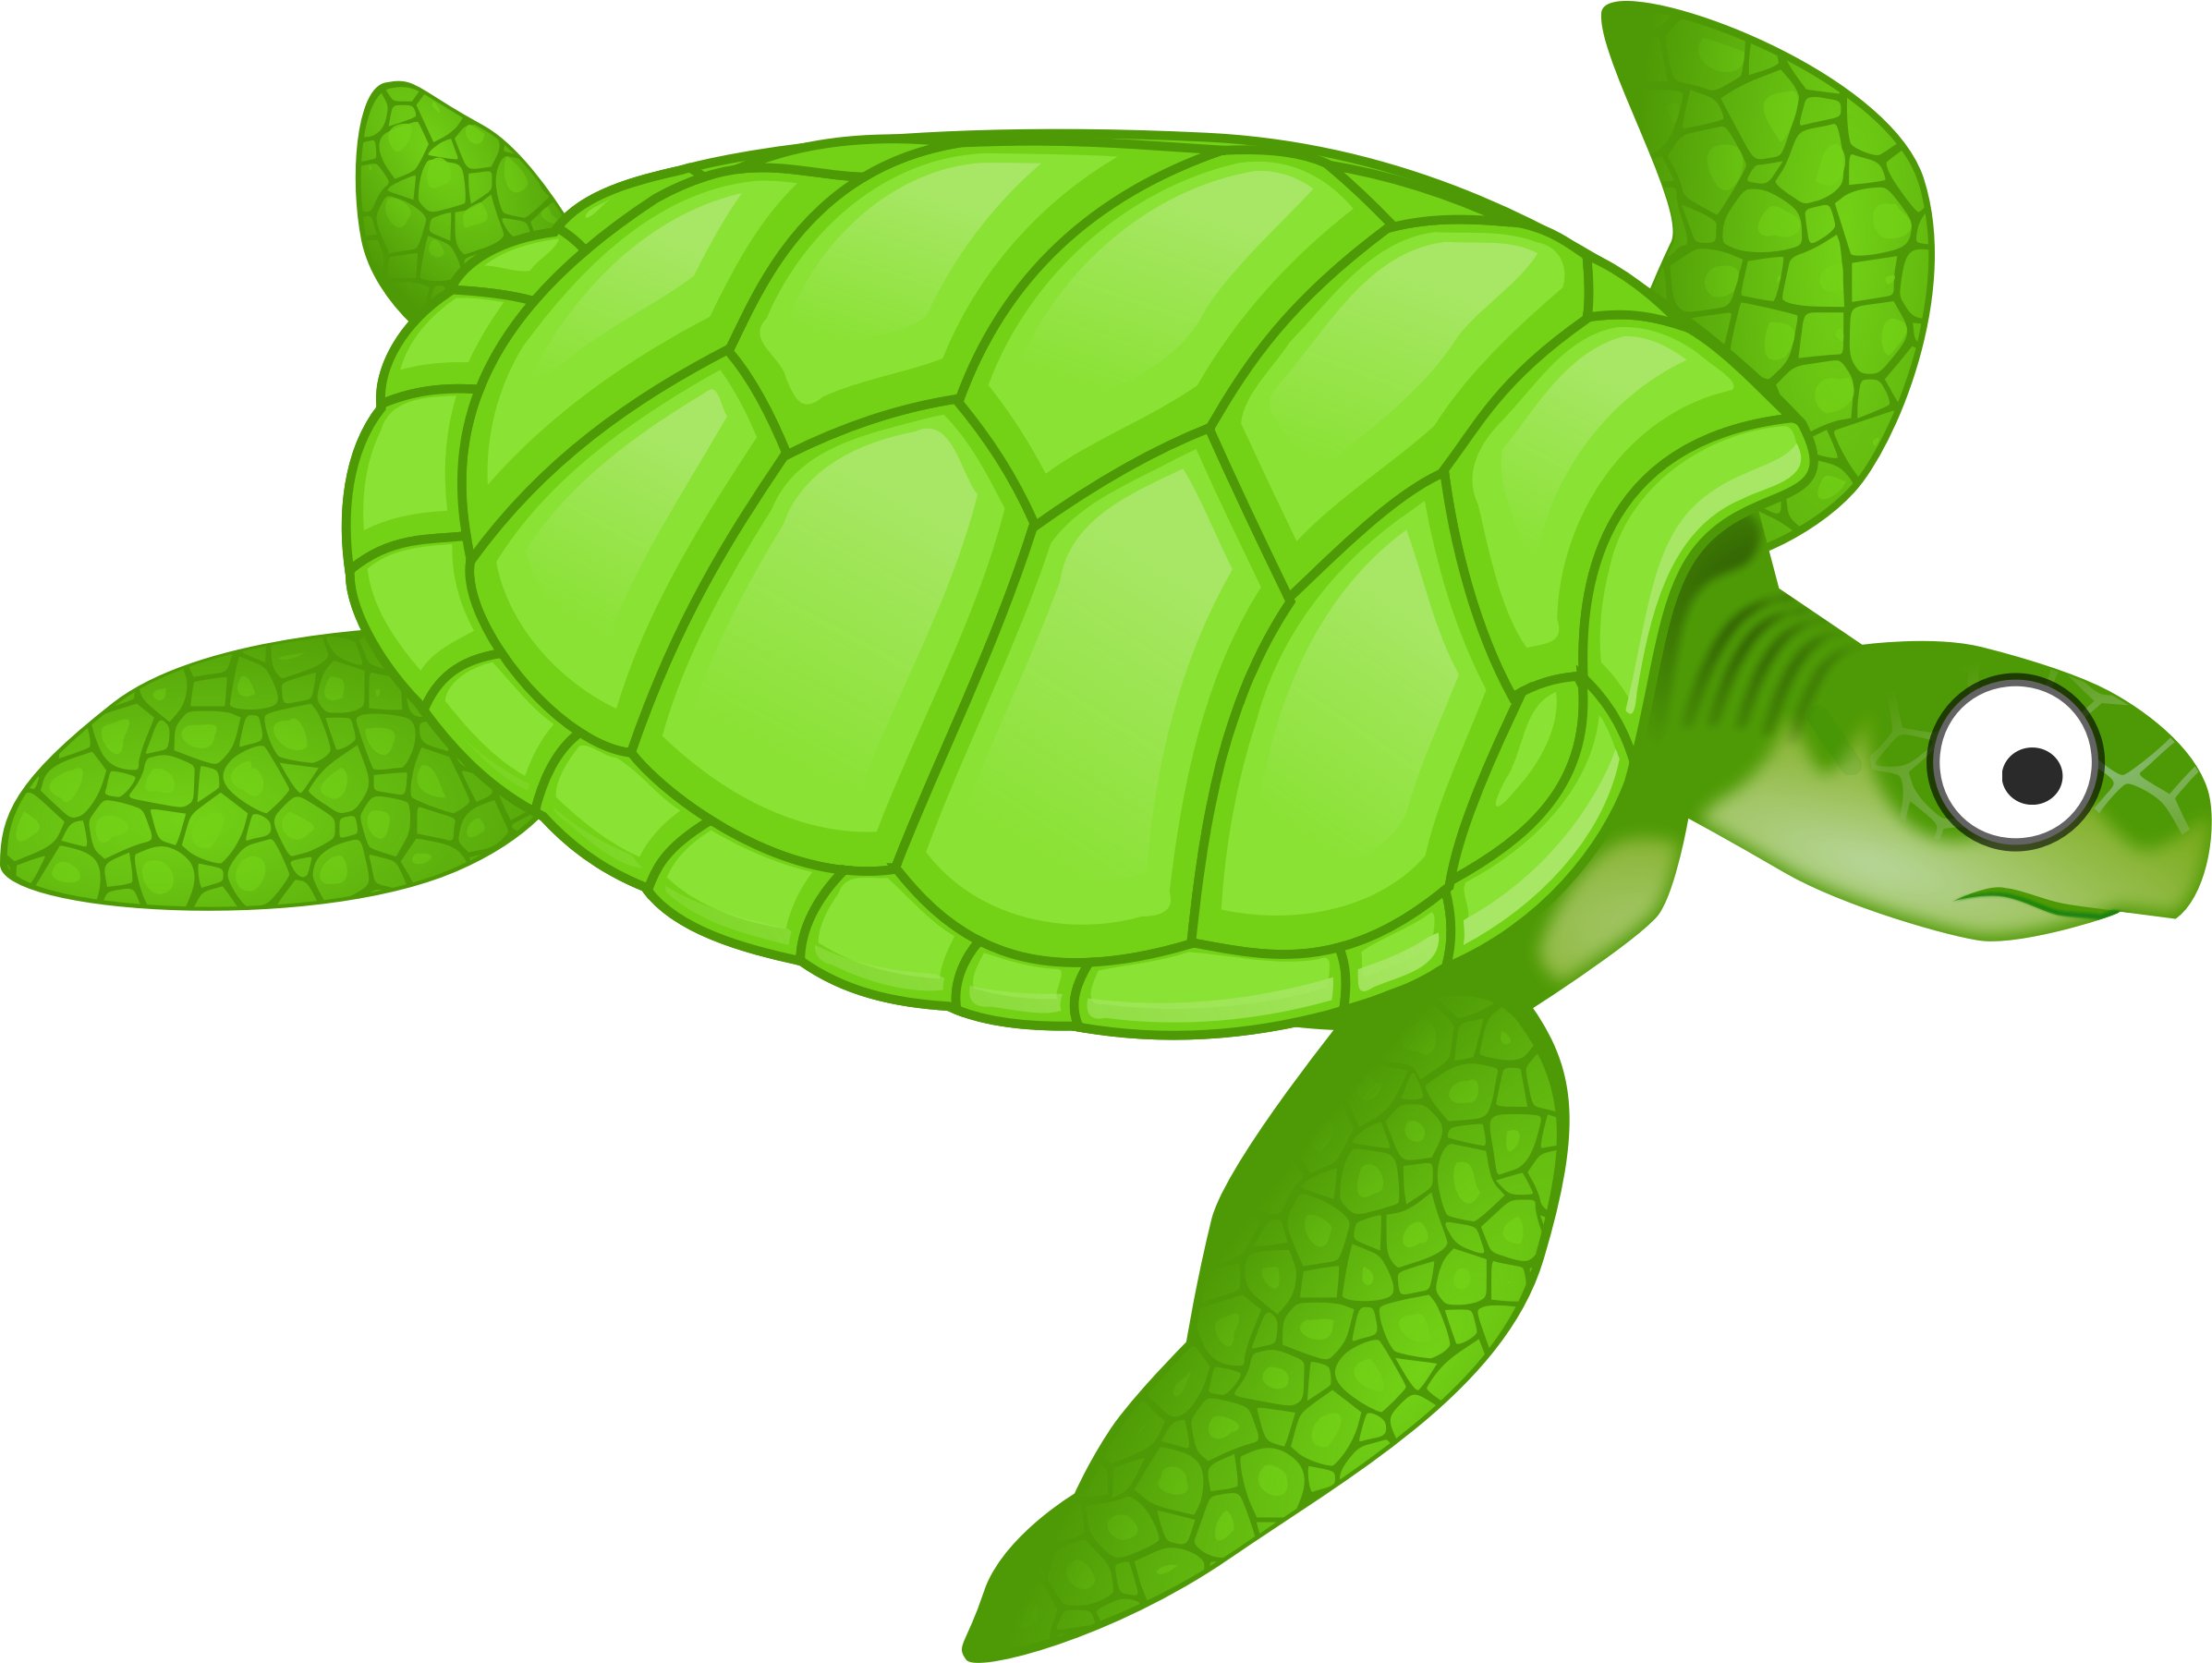

In [ ]:
turtle_image

In [ ]:
# to create the training set, we will resize the turtle image to 256x256
turtle_image_256x256 = turtle_image.resize((256, 256))

from this cell to

In [ ]:
import os
from scipy.ndimage import gaussian_filter
import numpy as np
import torch
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.models.detection import MaskRCNN
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

# Initialize transform

In [ ]:
#code to generate similar images
def generate_turtle_images(num_images=50, output_dir="turtle_dataset", size=(256, 256)):
    # Create directories
    img_dir = os.path.join(output_dir, "images")
    mask_dir = os.path.join(output_dir, "masks")
    os.makedirs(img_dir, exist_ok=True)
    os.makedirs(mask_dir, exist_ok=True)



    turtle_img = Image.open('./turtle.png')

    # Resize turtle
    target_height = 150
    aspect_ratio = turtle_img.size[0] / turtle_img.size[1]
    target_width = int(target_height * aspect_ratio)
    turtle_img = turtle_img.resize((target_width, target_height), Image.LANCZOS)

    for i in range(num_images):
        # Generate background with gaussian noise
        noise = np.random.randint(0, 255, (size[0], size[1], 3), dtype=np.uint8)
        smoothed = np.zeros_like(noise)
        for j in range(3):
            smoothed[:,:,j] = gaussian_filter(noise[:,:,j], sigma=5)
        background = Image.fromarray(smoothed).convert('RGBA')

        # Create new image and mask
        image = Image.new('RGBA', size, (0, 0, 0, 0))
        mask = Image.new('L', size, 0)

        # Random position and rotation
        x = random.randint(0, size[0] - turtle_img.size[0])
        y = random.randint(0, size[1] - turtle_img.size[1])
        angle = random.randint(0, 360)
        rotated_turtle = turtle_img.rotate(angle, expand=True)

        # Create image and mask
        image.paste(rotated_turtle, (x, y), rotated_turtle)
        mask_data = np.array(image.split()[3])
        mask_data = (mask_data > 0).astype(np.uint8) * 255
        mask = Image.fromarray(mask_data)

        # Save files
        final_image = Image.alpha_composite(background, image).convert('RGB')
        final_image.save(os.path.join(img_dir, f"turtle_{i:03d}.png"))
        mask.save(os.path.join(mask_dir, f"turtle_{i:03d}_mask.png"))

    print(f"Generated {num_images} images in {output_dir}")
generate_turtle_images(num_images=50)                #need big data set for training genrate more images




Generated 50 images in turtle_dataset


In [ ]:
from torch.utils.data import Dataset, DataLoader

In [ ]:
# Define the custom dataset class
class CustomDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transforms=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transforms = transforms
        self.images = list(sorted(os.listdir(image_dir)))
        self.masks = list(sorted(os.listdir(mask_dir)))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)

        # Convert mask to numpy array
        mask = np.array(mask)
        obj_ids = np.unique(mask)
        obj_ids = obj_ids[1:]

        masks = mask == obj_ids[:, None, None]
        num_objs = len(obj_ids)
        boxes = []

        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "masks": masks,
            "image_id": image_id,
            "area": area,
            "iscrowd": iscrowd,
        }

        if self.transforms:
            img = self.transforms(img)

        return img, target

In [ ]:
from torchvision import transforms
# converting tensor form
transform = transforms.Compose([
    transforms.ToTensor(),
])

In [ ]:
image_dir = '/content/turtle_dataset/images'
mask_dir = '/content/turtle_dataset/masks'
dataset = CustomDataset(image_dir=image_dir, mask_dir=mask_dir, transforms=transform)
data_loader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.models.detection import MaskRCNN
import torch
# Load a ResNet-101 backbone
backbone = resnet_fpn_backbone('resnet101', pretrained=True)
# backbone = resnet_fpn_backbone('resnet50', pretrained=True)

model = MaskRCNN(backbone, num_classes=2)

# # Move model to device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Define optimizer and learning rate scheduler
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'backbone_name' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-

In [ ]:
# Training loop
num_epochs = 6                                   #need to train on more epoch
for epoch in range(num_epochs):
    model.train()
    i = 0
    for images, targets in data_loader:
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        i += 1
        if i % 10 == 0:
            print(f'Iteration {i}, Loss: {losses.item()}')

    lr_scheduler.step()
    print(f'Epoch {epoch+1}, Loss: {losses.item()}')


Iteration 10, Loss: 4.3342719078063965
Iteration 20, Loss: 0.7085355520248413
Epoch 1, Loss: 0.4960988163948059
Iteration 10, Loss: 2.2501888275146484
Iteration 20, Loss: 0.7781987190246582
Epoch 2, Loss: 0.7814597487449646
Iteration 10, Loss: 0.394209623336792
Iteration 20, Loss: 0.3165707588195801
Epoch 3, Loss: 0.32857608795166016
Iteration 10, Loss: 0.2557147145271301
Iteration 20, Loss: 0.2674976885318756
Epoch 4, Loss: 0.3061278760433197
Iteration 10, Loss: 0.2964143753051758
Iteration 20, Loss: 0.2927320599555969
Epoch 5, Loss: 0.25335755944252014
Iteration 10, Loss: 0.26043930649757385
Iteration 20, Loss: 0.24069812893867493
Epoch 6, Loss: 0.2652449309825897


In [ ]:

def save_checkpoint(model, optimizer, scheduler, epoch, loss, filename):
    """Save model checkpoint with all states"""
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, filename)

def load_checkpoint(model, optimizer, scheduler, filename):

    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    return checkpoint['epoch'], checkpoint['loss']

# Save after training
save_checkpoint(
    model,
    optimizer,
    lr_scheduler,
    num_epochs,
    losses.item(),
    'mask_rcnn_checkpoint.pth'
)



In [ ]:
gdown.download("https://drive.google.com/uc?id=1_55KX8AK8pZ936Zv27t8Q-ZY8BJjuBqa", "test.png", quiet=False)
url = "https://drive.google.com/uc?id=1_55KX8AK8pZ936Zv27t8Q-ZY8BJjuBqa"

# Specify the output path where the file will be saved
output = "test.png"
# Load and preprocess the image
# image = Image.open("test.png").convert("RGB")
# transform = transforms.Compose([transforms.ToTensor()])
# image_tensor = transform(image).unsqueeze(0)  # Add batch dimension


Downloading...
From: https://drive.google.com/uc?id=1_55KX8AK8pZ936Zv27t8Q-ZY8BJjuBqa
To: /content/test.png
100%|██████████| 413k/413k [00:00<00:00, 73.9MB/s]


In [ ]:
#preprocess the image
image = Image.open("test.png").convert("RGB")
transform = transforms.Compose([transforms.ToTensor()])
image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

# Perform inference
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device).eval()
image_tensor = image_tensor.to(device)
with torch.no_grad():
    prediction = model(image_tensor)[0]

In [ ]:
# Move model and input tensor to the same device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
image_tensor = image_tensor.to(device)

with torch.no_grad():
    prediction = model(image_tensor)

In [ ]:
# Process the prediction
import cv2

masks = (prediction[0]['masks'] > 0.8).squeeze().cpu().numpy()
boxes = prediction[0]['boxes'].cpu().numpy()
labels = prediction[0]['labels'].cpu().numpy()

image_np = np.array(image)

# Generate random colors for each mask
colors = np.random.randint(0, 255, (len(masks), 3), dtype=np.uint8)

# Create an overlay for masks
overlay = np.zeros(image_np.shape, dtype=np.uint8)
for i, mask in enumerate(masks):
    colored_mask = np.zeros_like(image_np, dtype=np.uint8)
    for c in range(3):
        colored_mask[:, :, c] = np.where(mask, colors[i, c], 0)
    overlay = cv2.addWeighted(overlay, 1, colored_mask, 0.5, 0)


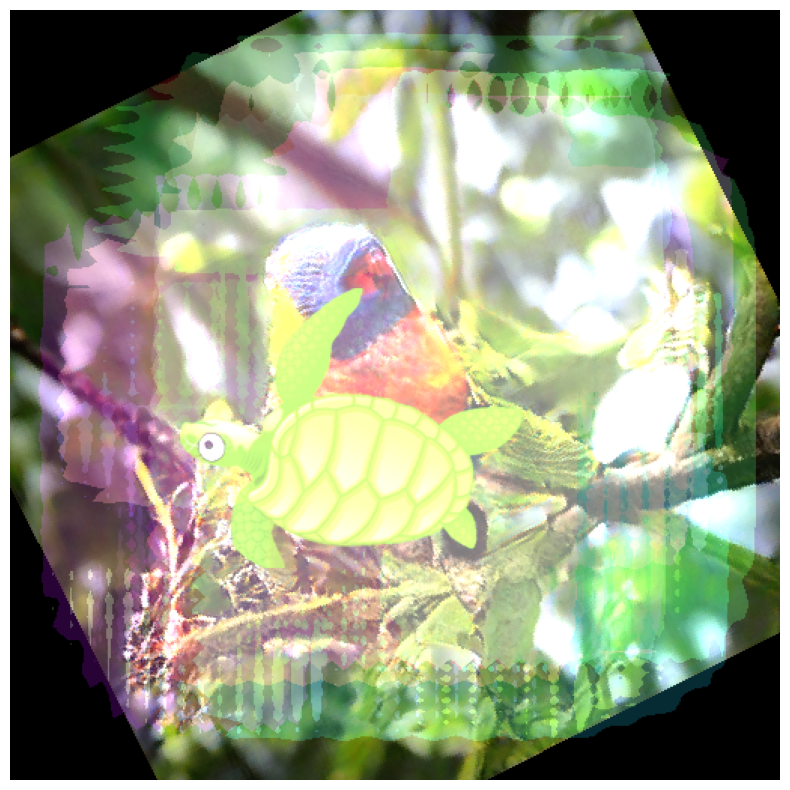

In [ ]:
import cv2
from PIL import Image

image_with_overlay = cv2.addWeighted(image_np, 1, overlay, 0.5, 0)

# Draw bounding boxes
for box in boxes:
    start_point = (int(box[0]), int(box[1]))
    end_point = (int(box[2]), int(box[3]))

# Display the result
plt.figure(figsize=(10, 10))
plt.imshow(image_with_overlay)
plt.axis('off')
plt.show()

In [ ]:

tensor_transform = transforms.Compose([
    transforms.ToTensor(),
])


<ipython-input-30-0bd21abf3edf>:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(saved_model_path)


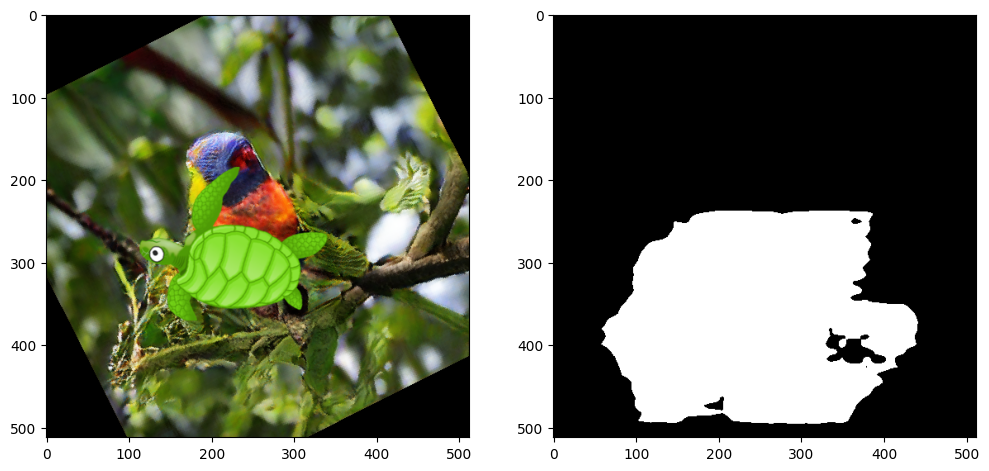

In [ ]:

# Load test image
test_image_path = "/content/test.png"  # Load your test image here
test_image = Image.open(test_image_path).convert("RGB")
test_image_tensor = tensor_transform(test_image)

load_model_weights = True

def get_mask_from_image(test_image, model=None, device=None):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    if model is None:
        backbone = resnet_fpn_backbone('resnet101', pretrained=True)
        model = MaskRCNN(backbone, num_classes=2)
        checkpoint = torch.load("/content/mask_rcnn_checkpoint.pth")
        model.load_state_dict(checkpoint['model_state_dict'])
        model.to(device)

    model.eval()

    image = test_image.unsqueeze(0).to(device)

    with torch.no_grad():
        prediction = model(image)

    mask = prediction[0]['masks'][0, 0].cpu()
    mask = (mask > 0.5).byte()

    return mask

# Setup device and model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = None

if load_model_weights:
    saved_model_path = "/content/mask_rcnn_checkpoint.pth"

    if os.path.exists(saved_model_path):
        backbone = resnet_fpn_backbone('resnet101', pretrained=True)
        model = MaskRCNN(backbone, num_classes=2)

        checkpoint = torch.load(saved_model_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        model.to(device)
        model.eval()
    else:
        print("Model checkpoint not found. Please ensure the path is correct.")

# Get prediction
test_mask_tensor = get_mask_from_image(test_image_tensor, model, device)

# Visualize results
plt.figure(figsize=(12, 12))
plt.subplot(121)
plt.imshow(test_image_tensor.permute(1, 2, 0).numpy())  # Change dimensions for display
plt.subplot(122)
plt.imshow(test_mask_tensor.numpy(), cmap="gray", vmin=0, vmax=1)
plt.show()


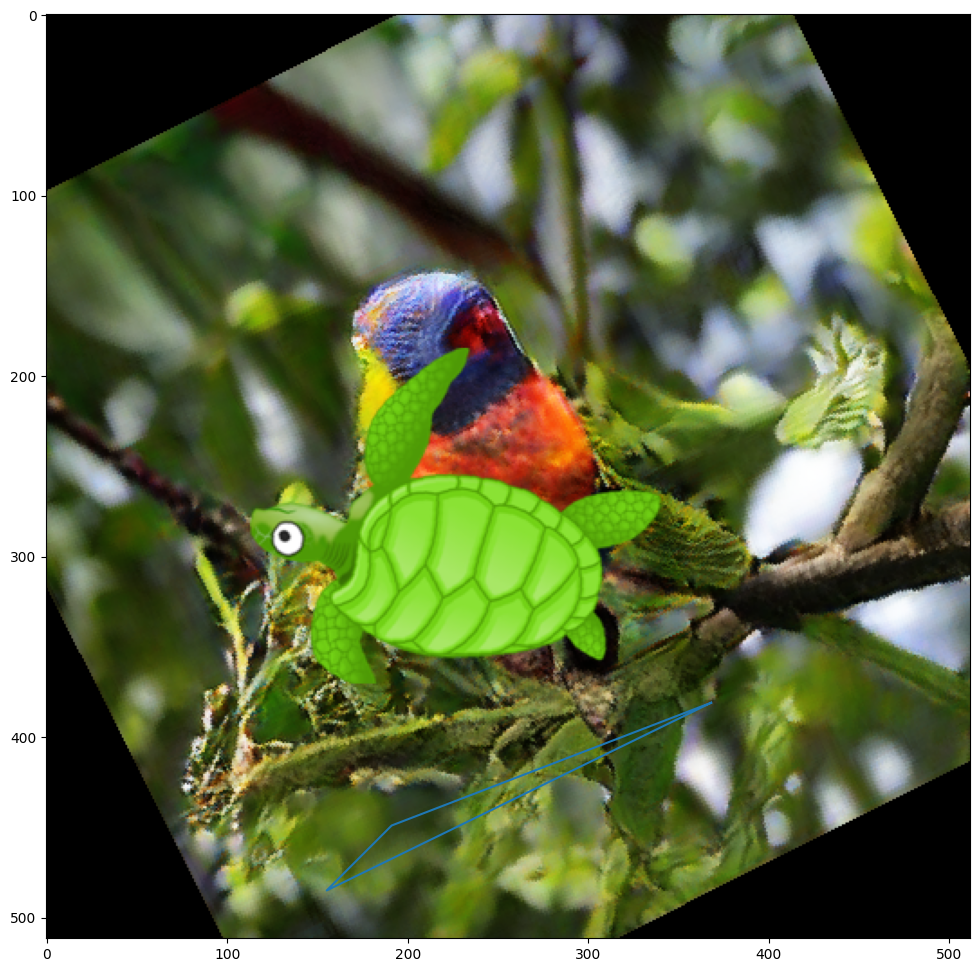

In [ ]:
def get_tight_polygon_from_mask(test_mask):
  # TODO: Implement an algorithm that computes the enclosing polygon from the segmentation mask.
  mask_points_n2 = torch.stack(torch.where(test_mask_tensor == 1), 1)
  dummy_polygon_points_n2 = mask_points_n2[torch.randperm(mask_points_n2.size(0))[:3], :]
  return dummy_polygon_points_n2

def visualize_polygon_on_image(test_image, polygon_points_n2):
  # append first point to close the figure
  polygon_points_n2 = torch.cat([polygon_points_n2, polygon_points_n2[:1]], 0)
  ys, xs = torch.split(polygon_points_n2, 1, dim=-1)
  plt.figure(figsize=(12, 12))
  plt.imshow(test_image.numpy().transpose(1, 2, 0))
  plt.plot(xs.numpy(), ys.numpy())
polygon_points_n2_tensor = get_tight_polygon_from_mask(test_mask_tensor)
visualize_polygon_on_image(test_image_tensor, polygon_points_n2_tensor)

In [ ]:

def calculate_polygon_area(polygon_points_n2):
    # Assuming polygon_points_n2 is a NumPy array of shape (n, 2) containing [x, y] coordinates of the polygon vertices
    x = polygon_points_n2[:, 0]
    y = polygon_points_n2[:, 1]
    # Calculate the area using the Shoelace formula
    area = 0.5 * abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))
    return area
import numpy as np

# Assuming polygon_points_n2_tensor is defined and converted to a NumPy array
polygon_points_n2 = polygon_points_n2_tensor.numpy()
area = calculate_polygon_area(polygon_points_n2)
print("Area = {:.4f}".format(area))


Area = 1962.0000


#######last result####

# Background Images

As written above, we will use a generative adversarial network called "BigGAN" pre-trained on ImageNet to create a set of background images

In [ ]:
# first, we need to install the python package called `pytorch_pretrained_biggan` (https://github.com/huggingface/pytorch-pretrained-BigGAN)
# if in the notebook environment, please uncomment the following line to install this package
# !pip install pytorch_pretrained_biggan
# there might be some errors related to pip's dependency resolver which you can safely ignore

In [ ]:
!pip install pytorch-pretrained-biggan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 99.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.6/82.6 kB 7.4 MB/s eta 0:00:00


In [ ]:
import torch
from pytorch_pretrained_biggan import (
    BigGAN,
    truncated_noise_sample,
    convert_to_images,
    one_hot_from_int,
)

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# boilerplate pytorch code enforcing reproducibility
torch.manual_seed(42)
if device.type == "cuda":
    torch.cuda.manual_seed(42)
np.random.seed(42)
random.seed(42)

BigGAN is a memory-intensive network.

To save time and memory, we will only generate 30 different background images.
Feel free to change this setup as needed.

In [ ]:
# load the 256x256 model
model = BigGAN.from_pretrained('biggan-deep-256').to(device).eval()

# every time we will run with batch size of 3 in order to not run out of memory
num_passes = 10
batch_size = 3

# default noise value from the provided repository
truncation = 0.4

background_images = []

for _ in range(num_passes):
    # BigGAN uses imagenet and hence each time we will choose one of 1000 categories
    class_vector = torch.from_numpy(
        one_hot_from_int(np.random.randint(0, 1000, size=batch_size), batch_size=batch_size)
    ).to(device)
    noise_vector = torch.from_numpy(
        truncated_noise_sample(truncation=truncation, batch_size=batch_size)
    ).to(device)

    # Generate the images and convert them to PIL image
    with torch.no_grad():
        output = model(noise_vector, class_vector, truncation).cpu()
        background_images.extend(convert_to_images(output))

# We won't need the GAN model anymore,
# so we can safely delete it and free up some memory
del model
torch.cuda.empty_cache()

100%|██████████| 715/715 [00:00<00:00, 1601991.11B/s]
/usr/local/lib/python3.10/dist-packages/pytorch_pretrained_biggan/model.py:279: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feat

Downloading...
From: https://drive.google.com/uc?id=1_55KX8AK8pZ936Zv27t8Q-ZY8BJjuBqa
To: /content/test.png
100%|██████████| 413k/413k [00:00<00:00, 69.4MB/s]


RGB (512, 512)


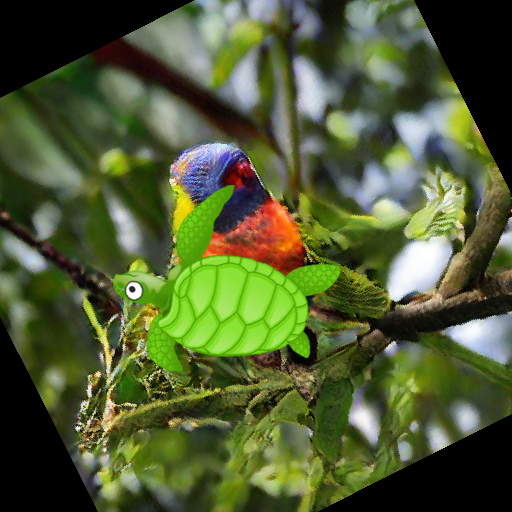

In [ ]:
gdown.download("https://drive.google.com/uc?id=1_55KX8AK8pZ936Zv27t8Q-ZY8BJjuBqa", "test.png", quiet=False)
test_image = Image.open('./test.png')
# it is a 3-channel RGB image of size 512x512
print(test_image.mode, test_image.size)
test_image

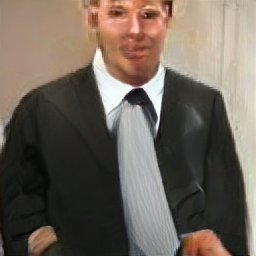

In [ ]:
# Let's see how one of the images look like
random.choice(background_images)

# Training Set
Given 30 background images and the turtle image, we will paste the turtle onto the background images.

In [ ]:
import torchvision
import torchvision.transforms as transforms

In [ ]:
tensor_transform = transforms.ToTensor()

def random_paste(background_image, turtle_image, min_scale=0.25, max_scale=0.65):
    """Randomly scales and pastes the turtle image onto the background image"""

    w, h = turtle_image.size
    # first, we will randomly downscale the turtle image
    new_w = int(random.uniform(min_scale, max_scale) * w)
    new_h = int(random.uniform(min_scale, max_scale) * h)
    resized_turtle_image = turtle_image.resize((new_w, new_h))

    # second, will randomly choose the locations where to paste the new image
    start_w = random.randint(0, w - new_w)
    start_h = random.randint(0, h - new_h)

    # third, will create the blank canvas of the same size as the original image
    canvas_image = Image.new('RGBA', (w, h))

    # and paste the resized turtle onto it, preserving the mask
    canvas_image.paste(resized_turtle_image, (start_w, start_h), resized_turtle_image)

    # Turtle image is of mode RGBA, while background image is of mode RGB;
    # `.paste` requires both of them to be of the same type.
    background_image = background_image.copy().convert('RGBA')
    # finally, will paste the resized turtle onto the background image
    background_image.paste(resized_turtle_image, (start_w, start_h), resized_turtle_image)
    return background_image, canvas_image

In [ ]:
training_set = []  # image, segmentation mask

for background_image in background_images:
  # paste the turtle onto background image
  aug_image, aug_mask = random_paste(background_image.copy(), turtle_image_256x256.copy())
  # convert PIL images to pytorch tensors
  training_pair = [
      tensor_transform(aug_image)[:3],  # keep the rgb only
      # For the mask, we only need the last (4th) channel,
      # and we will encode the mask as boolean
      tensor_transform(aug_mask)[-1:] > 0,
  ]
  training_set.append(training_pair)

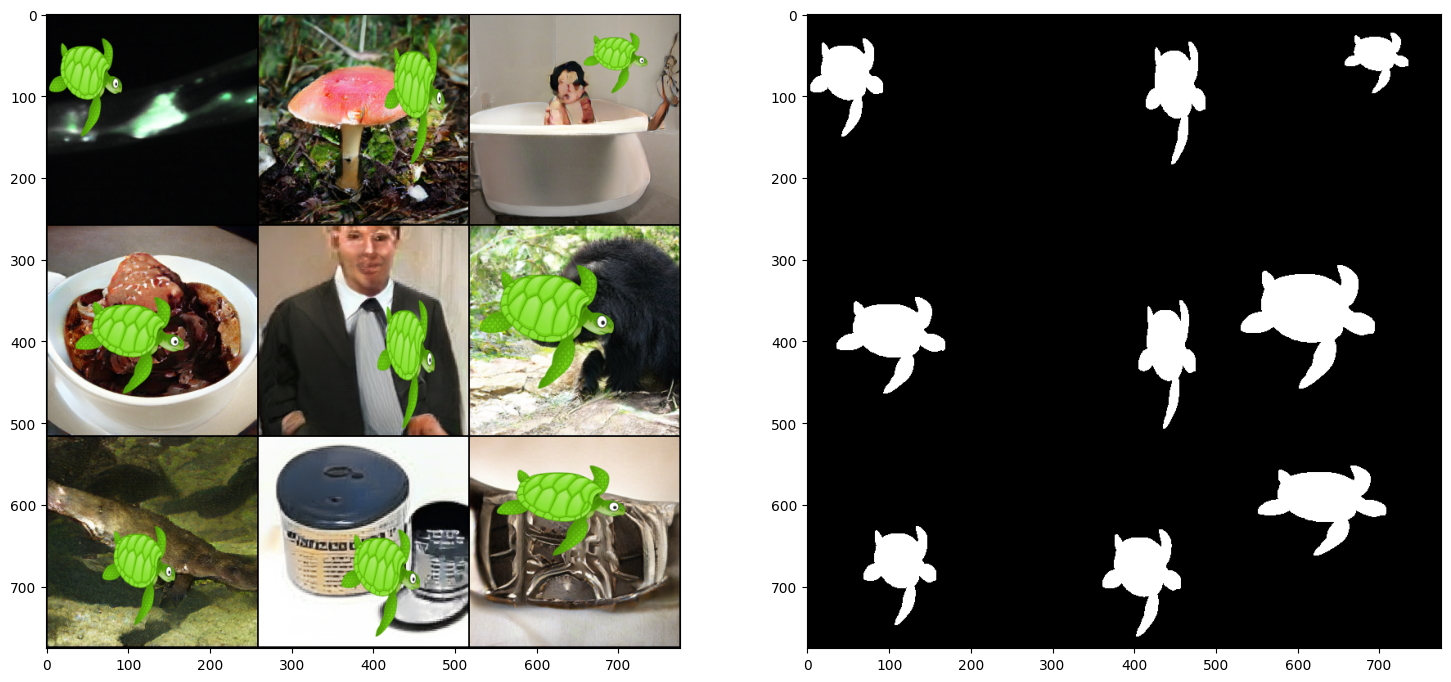

In [ ]:
# Let's visualise some subset of the training set
sample_indices = np.random.choice(len(training_set), size=9, replace=False)
sample_images = []
sample_masks = []
for i in sample_indices:
    image, mask = training_set[i]
    sample_images.append(image)
    sample_masks.append(mask)

plt.figure(figsize=(18, 18))
plt.subplot(121)
plt.imshow(torchvision.utils.make_grid(sample_images, nrow=3).permute(1, 2, 0).cpu().numpy())
plt.subplot(122)
plt.imshow(torchvision.utils.make_grid(sample_masks, nrow=3).permute(1, 2, 0).float().cpu().numpy())

# Test Image
Now, let's load the test image. As mentioned above, it is of a slightly higher 512x512 resolution.

Downloading...
From: https://drive.google.com/uc?id=1_55KX8AK8pZ936Zv27t8Q-ZY8BJjuBqa
To: /content/test.png
100%|██████████| 413k/413k [00:00<00:00, 56.1MB/s]

RGB (512, 512)


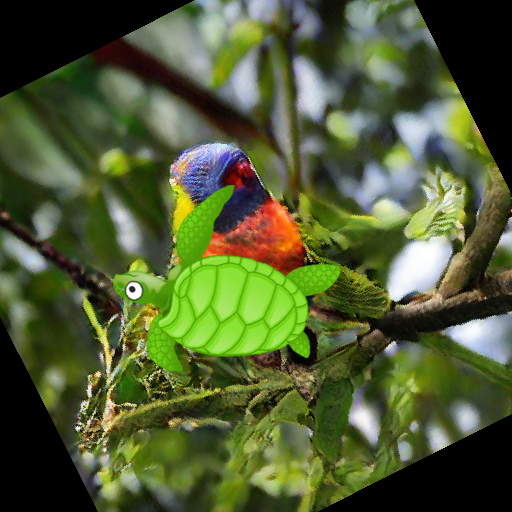

In [ ]:
gdown.download("https://drive.google.com/uc?id=1_55KX8AK8pZ936Zv27t8Q-ZY8BJjuBqa", "test.png", quiet=False)
test_image = Image.open('./test.png')
# it is a 3-channel RGB image of size 512x512
print(test_image.mode, test_image.size)
test_image

# Task 1: Predicting segmentation mask

*This is where you need to implement your deep learning solution. Your approach should output a result at the native 512x512 resolution of the test image.*

In [ ]:
# TODO: Implement and train the deep model

# TODO: Save the model weights and upload them to Google Drive

# load_model_weights = False
if load_model_weights:
    # After uploading your saved model weights to Google Drive, share to
    # "Anyone with the link" and extract FILE_ID from the share link
    # See https://support.google.com/drive/answer/2494822?hl=en&co=GENIE.Platform%3DDesktop
    # for more information
    # Now the weights can be downloaded and used via gdown:
    saved_model_url = "/content/turtle_model.pth"
    gdown.download(saved_model_url, "saved_model.pth", quiet=True)

    # TODO: Load your saved model weights e.g. torch.load("saved_model.pth")

test_image_tensor = tensor_transform(test_image)

def get_mask_from_image(test_image):
  # TODO: Use the deep model that predicts the segmentation mask on the test image
  # The model with the saved weights should be used, if load_model_weights is True
  test_mask = test_image.mean(0) < 0.5
  return test_mask.byte()

test_mask_tensor = get_mask_from_image(test_image_tensor)

plt.figure(figsize=(12, 12))
plt.subplot(121)
plt.imshow(test_image_tensor.numpy().transpose(1, 2, 0))
plt.subplot(122)
plt.imshow(test_mask_tensor.numpy(), cmap="gray", vmin=0, vmax=1)

NameError: name 'load_model_weights' is not defined

# Task 2: Calculating tight enclosing polygon from segmentation mask

*This is where you need to implement your algorithm that predicts a convex hull, an enclosing polygon of foreground pixels. You are not allowed to use cv2, scikit-image or other libraries' functionality that readily solve this task. Treat this problem as point-based rather than the image-based one.*

*You don't have to use PyTorch for this part. Your approach should output a result at the native 512x512 resolution of the test image.*

*For the purposes of this assignment, O(n^2) is considered a good time complexity*

In [ ]:
def get_tight_polygon_from_mask(test_mask):
  # TODO: Implement an algorithm that computes the enclosing polygon from the segmentation mask.
  mask_points_n2 = torch.stack(torch.where(test_mask_tensor == 1), 1)
  dummy_polygon_points_n2 = mask_points_n2[torch.randperm(mask_points_n2.size(0))[:3], :]
  return dummy_polygon_points_n2

def visualize_polygon_on_image(test_image, polygon_points_n2):
  # append first point to close the figure
  polygon_points_n2 = torch.cat([polygon_points_n2, polygon_points_n2[:1]], 0)
  ys, xs = torch.split(polygon_points_n2, 1, dim=-1)
  plt.figure(figsize=(12, 12))
  plt.imshow(test_image.numpy().transpose(1, 2, 0))
  plt.plot(xs.numpy(), ys.numpy())


polygon_points_n2_tensor = get_tight_polygon_from_mask(test_mask_tensor)
visualize_polygon_on_image(test_image_tensor, polygon_points_n2_tensor)


# Task 3 : Calculating the area of the polygon
*This is where you need to implement your area calculation algorithm. You are not allowed to use cv2, scikit-image or other libraries' functionality that readily solve this task. Once again, treat this problem as a point-based rather than the image-based one.*

*You don't have to use PyTorch for this part. Your approach should output a result at the native 512x512 resolution of the test image.*

In [ ]:
def calculate_polygon_area(polygon_points_n2):
  # TODO: Implement the algorithm
  area = 0.0
  return area

print("Area = {:.4f}".format(calculate_polygon_area(polygon_points_n2_tensor)))